In [169]:
import seaborn as sns
import sys
import csv
import datetime
import operator
import joblib
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from statsmodels.formula.api import ols
from sklearn.metrics import cohen_kappa_score
from collections import OrderedDict
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from scipy.stats import norm, skew, probplot

In [170]:
data_path = '../titanic/'

df_train = pd.read_csv(data_path + 'train.csv' , index_col = 'PassengerId')
df_test = pd.read_csv(data_path + 'test.csv' , index_col = 'PassengerId')
gender_submission = pd.read_csv(data_path + 'gender_submission.csv' , index_col= 'PassengerId')

## EDA

In [171]:
df_train.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [172]:
df_test.head(5)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [173]:
gender_submission.head(5)
# head()를 활용하여 볼때 PassengerId를 통해서 test data의 결과를 예측할 수 있음을 예상할 수 있습니다.

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


In [174]:
# 'Survived' column을 잘 붙였는지 확인 합니다.
df_test['Survived'] = gender_submission['Survived']
df_test.head(5)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
PassengerId,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


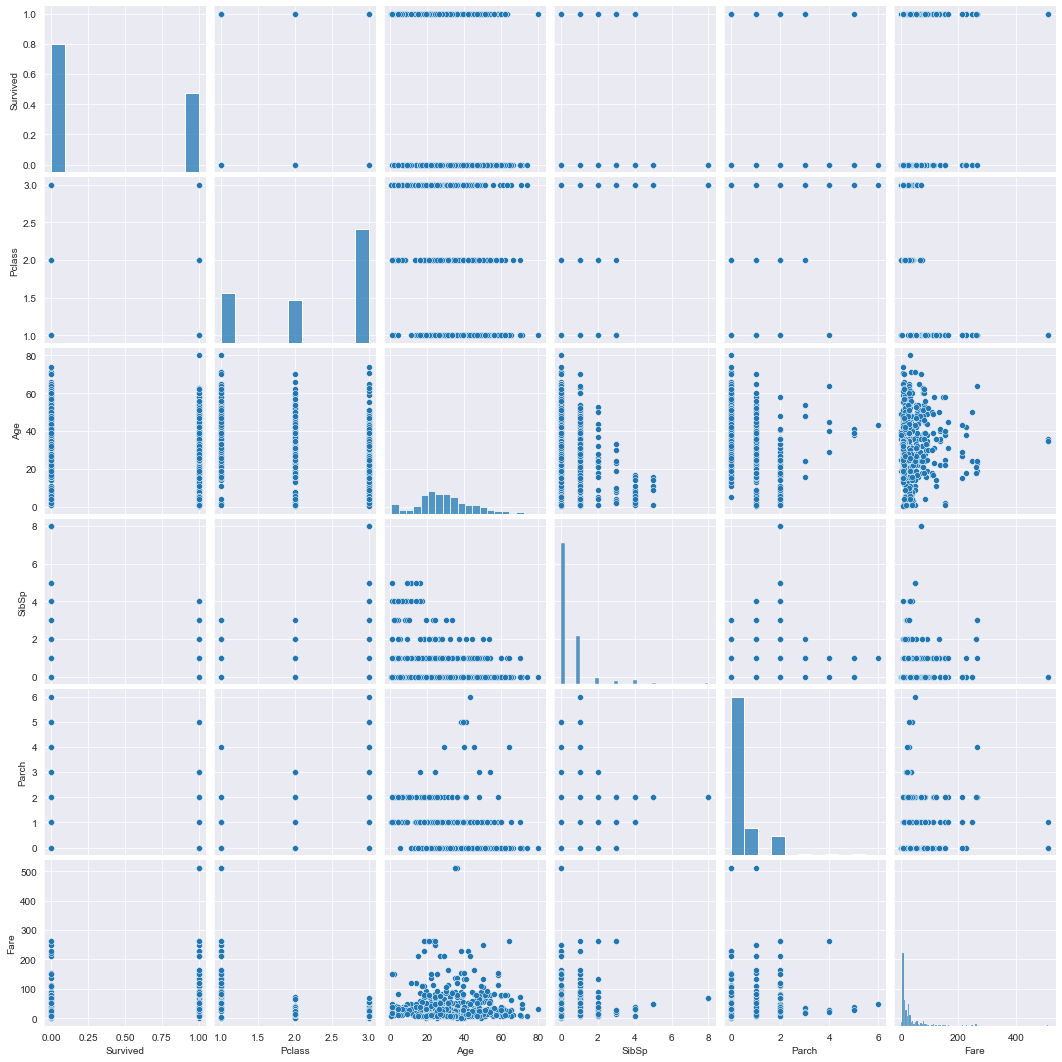

In [175]:
#통계적으로 분포가 어떠한지 Pair Plot 및 여러 그래프를 통하여 분석해 보겠습니다.

sns.pairplot(data = df_train) # 연속형 피처만 한듯

In [176]:
def analysis(data):
    print("1. 첫번째 그래프는 Data의 Heatmap 분석 결과입니다.상관관계가 높을수록 색깔이 진하도록 표시하였습니다.")
    print("2. 두번째 그래프는 null ratio를 그래프로 표시하였습니다.")
    sns.heatmap(data.corr(), annot=True, cmap='Reds')
    null_percent = 100*(data.isnull().sum()/len(data))
    null_percent = null_percent[null_percent>0].sort_values()
    plt.figure(figsize= (10,4))
    sns.barplot(x=null_percent.index, y= null_percent)
    plt.xticks(rotation=90)

1. 첫번째 그래프는 Data의 Heatmap 분석 결과입니다.상관관계가 높을수록 색깔이 진하도록 표시하였습니다.
2. 두번째 그래프는 null ratio를 그래프로 표시하였습니다.


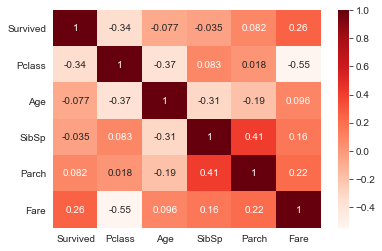

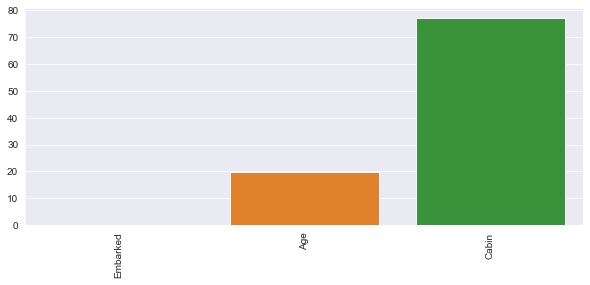

In [177]:
analysis(df_train)

1. 첫번째 그래프는 Data의 Heatmap 분석 결과입니다.상관관계가 높을수록 색깔이 진하도록 표시하였습니다.
2. 두번째 그래프는 null ratio를 그래프로 표시하였습니다.


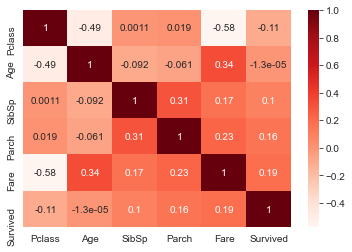

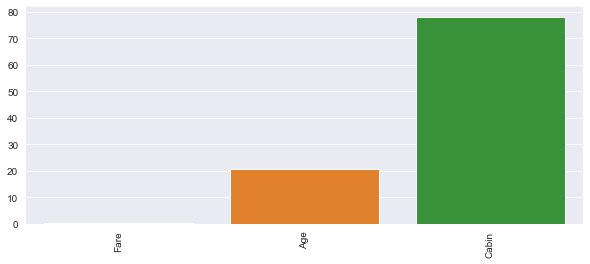

In [178]:
analysis(df_test)

In [179]:
fat=ols(formula='Survived~Pclass+Age+Sex+SibSp+Parch+Fare+Embarked', data=df_train).fit()
print(fat.summary())

# 통계적으로는 성별에 따른 구분과 Pclass에 따라 생존률이 영향도가 가장 높은 것으로 나왔고,
# OLS Regression으로 예측시 상기의 8개 변수만으로 본다면, R-squre 0.4/ Adjust R-square 0.39수준의 예측이 가능 할 것으로 예상 되었습니다.

                            OLS Regression Results                            
Dep. Variable:               Survived   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     58.84
Date:                Sat, 20 May 2023   Prob (F-statistic):           2.73e-73
Time:                        15:09:05   Log-Likelihood:                -321.06
No. Observations:                 712   AIC:                             660.1
Df Residuals:                     703   BIC:                             701.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.4031      0.082     17.214

In [180]:
# 숫자 타입의 데이터 추출

num_cols = [col for col in df_train.columns if df_train[col].dtype in ['int64','float64']]
df_train[num_cols].describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [181]:
df_train.corr(method='pearson') # 피어슨 상관계수 -1 ~ 1

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [182]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [183]:
# 데이터내 중복 값은 없는지 확인해 보겠습니다.


df_train=df_train.drop_duplicates()

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


skew: 0.4785234382949897
kert: -1.775004671066304


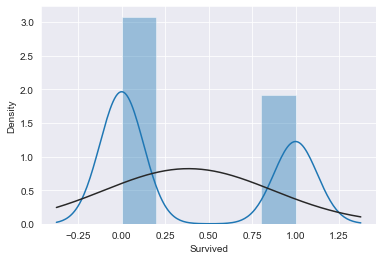

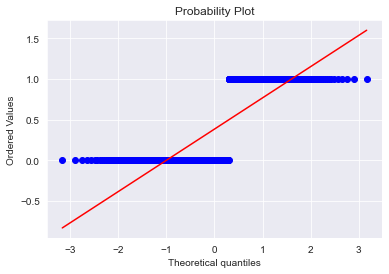

In [184]:
# 왜도와 첨도를 확인하는 경우 Regression Modeling할 경우 많이 보나, 금번의 경우는 단순히 우리가 알고 싶은 Y값(Survived)의 분포가 3:2라는 것
# 정도 밖의 정보를 얻을수 없었습니다.

print(f'skew: {df_train.Survived.skew()}')
print(f'kert: {df_train.Survived.kurt()}')
sns.distplot(df_train.Survived, fit = norm)
f = plt.figure()
probplot(df_train.Survived, plot = plt)
plt.show()
skew: 0.4785234382949897
kert: -1.775004671066304


In [185]:
def count_plot(d, y, x):
    plt.figure(figsize=(12,6))
    sns.countplot(x = d[y], hue = x, data=d)
    plt.ylabel('Number of people')
    plt.title('Survival count by '+ x)

Column내 변수가 20개 이상의 Column은 하단과 같습니다.
변수 20개 미만의 Column과 Survived 숫자 분포는 그래프와 같습니다.
['Age', 'Fare']


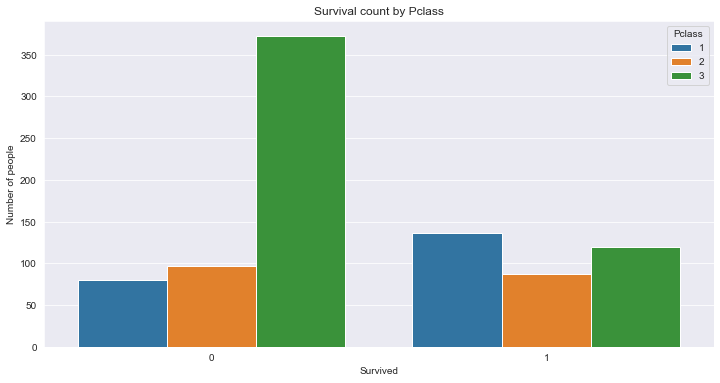

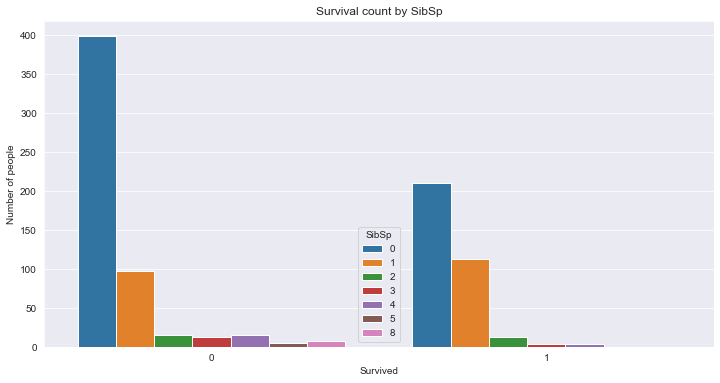

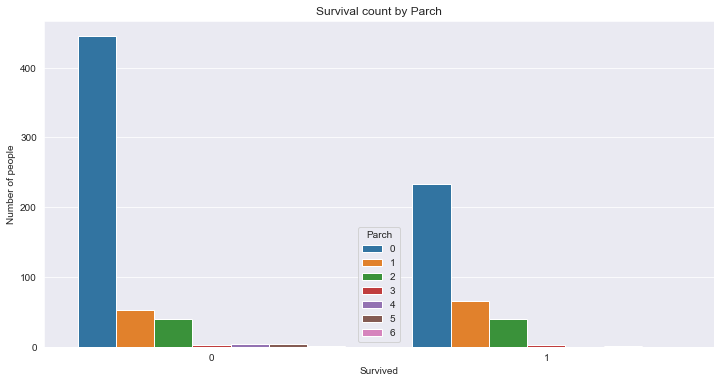

In [186]:
numeric_cols = [col for col in df_train if df_train[col].dtype in ['int64','float64']]
numeric_cols.remove('Survived')
y = 'Survived'
over_column_name = list()

for i in numeric_cols:
    if (len(df_train[i].value_counts())<20):
        count_plot(df_train, y, i)
    elif (len(df_train[i].value_counts())>20):
        over_column_name.append(i)

print('Column내 변수가 20개 이상의 Column은 하단과 같습니다.\n변수 20개 미만의 Column과 Survived 숫자 분포는 그래프와 같습니다.')
print(over_column_name)

['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


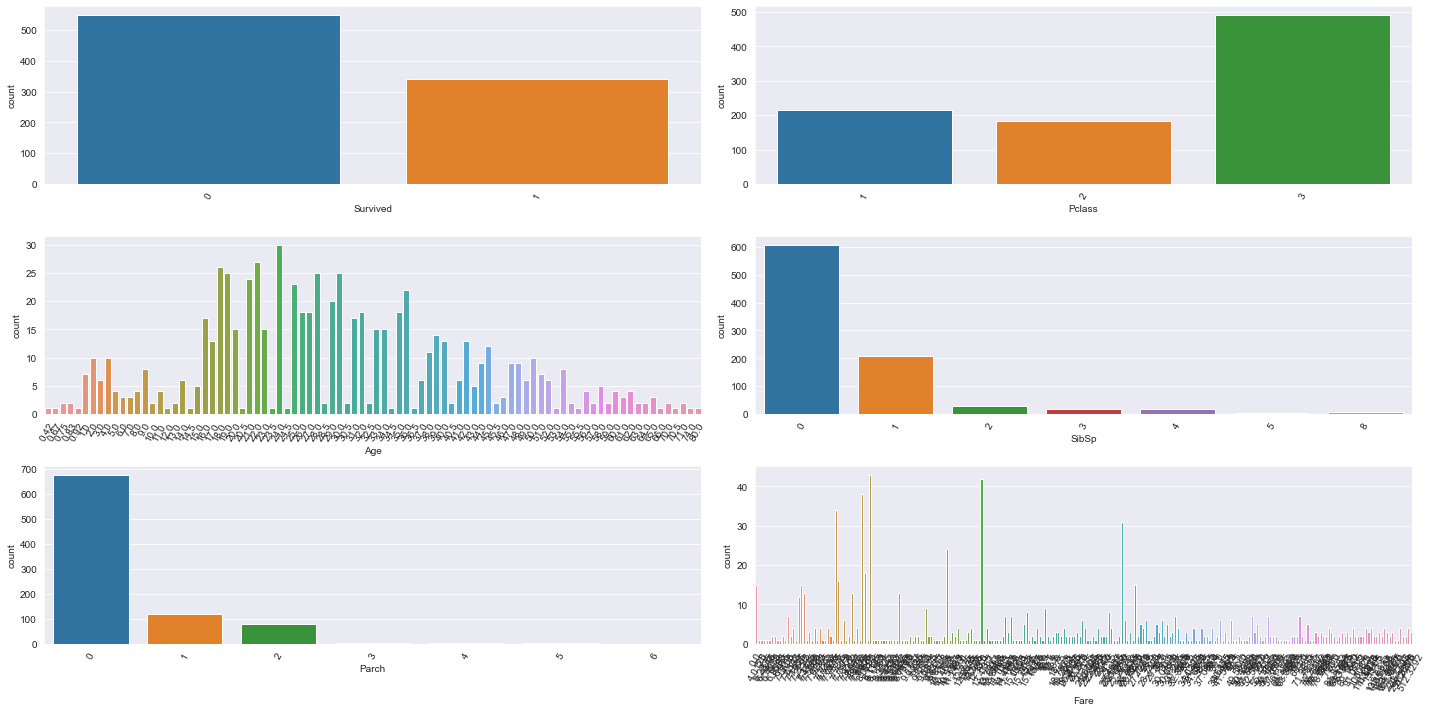

In [187]:
print(num_cols)
# num_cols.remove('PassengerId')

fig, ax = plt.subplots(3, 2, figsize=(20, 10))

for variable, subplot in zip(num_cols, ax.flatten()):
    sns.countplot(df_train[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(60)

plt.tight_layout()

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


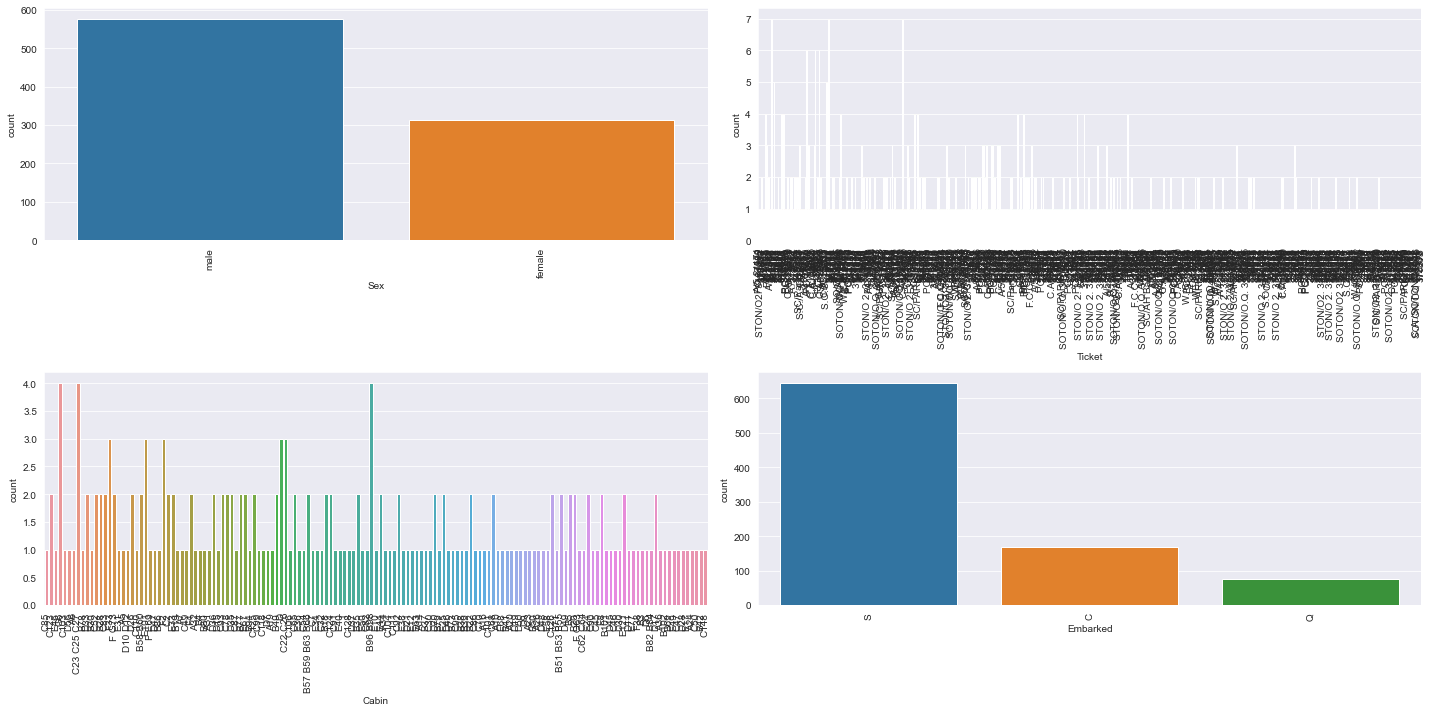

In [188]:
cat_cols = [col for col in df_train if df_train[col].dtype not in ['int64','float64']]
print(cat_cols)
cat_cols.remove('Name')

fig, ax = plt.subplots(2, 2, figsize=(20, 10))

for variable, subplot in zip(cat_cols, ax.flatten()):
    sns.countplot(df_train[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

plt.tight_layout()

In [189]:
# train data상 null값을 확인
df_train.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [190]:
df_train=df_train.drop(['Name','Ticket'],axis=1)
df_test=df_test.drop(['Name','Ticket'],axis=1)

In [191]:
# Cabin 정보는 다 버리기 아까워 글자수를 변수로 한번 활용해볼 생각입니다.

df_train['CabinCode'] = df_train['Cabin'].apply(lambda x : len(str(x)) if x!='nan' else 0)
df_test['CabinCode'] = df_test['Cabin'].apply(lambda x  : len(str(x)) if x!='nan' else 0)

In [192]:
df_train=df_train.drop(['Cabin'],axis=1)
df_test=df_test.drop(['Cabin'],axis=1)

In [193]:
# nan값 역시 하나의 변수가 아닐까라는 가정하에 금번 분석에서는 null값에 대한 보정 없이 진행해 보겠습니다.


df_train=pd.get_dummies(df_train)
df_test=pd.get_dummies(df_test)

In [194]:
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Age         714 non-null    float64
 3   SibSp       891 non-null    int64  
 4   Parch       891 non-null    int64  
 5   Fare        891 non-null    float64
 6   CabinCode   891 non-null    int64  
 7   Sex_female  891 non-null    uint8  
 8   Sex_male    891 non-null    uint8  
 9   Embarked_C  891 non-null    uint8  
 10  Embarked_Q  891 non-null    uint8  
 11  Embarked_S  891 non-null    uint8  
dtypes: float64(2), int64(5), uint8(5)
memory usage: 92.3 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      418 non-null    int64  
 1   Age         332 non-null

In [195]:
df_train.head(5)

,Survived,Pclass,Age,SibSp,Parch,Fare,CabinCode,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,3,0,1,0,0,1
2,1,1,38.0,1,0,71.2833,3,1,0,1,0,0
3,1,3,26.0,0,0,7.9250,3,1,0,0,0,1
4,1,1,35.0,1,0,53.1000,4,1,0,0,0,1
5,0,3,35.0,0,0,8.0500,3,0,1,0,0,1


## 모델링

In [196]:
# 7:3으로 제공된 train data를 train과 validation data로 구분

from sklearn.model_selection import train_test_split

random_state_val =42
test_size_val =0.3
train,validation = train_test_split(df_train, test_size = test_size_val, random_state = random_state_val)

In [197]:
drop_col = ['Survived']
y_nm = 'Survived'

df_train_x = train.drop(drop_col, axis = 1)
df_train_y = pd.DataFrame(train[y_nm])

df_val_x = validation.drop(drop_col, axis = 1)
df_val_y = pd.DataFrame(validation[y_nm])

df_test_x = df_test.drop(drop_col, axis = 1)
df_test_y = pd.DataFrame(df_test[y_nm])

In [198]:
LGBClassifier = lgb.LGBMClassifier(objective='binary',
                                   max_depth = 8,
                                   learning_rate = 0.01,
                                   n_estimators = 9000,
                                   max_bin = 200,
                                   bagging_freq = 4,
                                   bagging_seed = 8,
                                   feature_fraction = 0.2,
                                   feature_fraction_seed = 8,
                                   min_sum_hessian_in_leaf = 11,
                                   verbose = -1,
                                   random_state = 42)



In [199]:
start = datetime.datetime.now()
lgbm = LGBClassifier.fit(df_train_x.values,
                         df_train_y.values.ravel(),
                         eval_set = [(df_train_x.values, df_train_y), (df_val_x.values, df_val_y)],
                         eval_metric ='logloss',
                         early_stopping_rounds = 20,
                         verbose =False)
end = datetime.datetime.now()
end-start

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


datetime.timedelta(microseconds=905299)

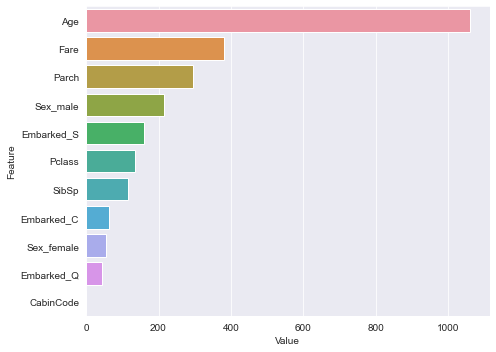

In [200]:
# Importance 확인
# 주요 영향을 미치는 변수가 무엇인지 확인을 하고, 이를 그래프화 진행하였습니다.

feature_imp= pd.DataFrame(sorted(zip(lgbm.feature_importances_, df_test_x.columns), reverse = True), columns = ['Value', 'Feature'])

plt.figure(figsize=(7,5))
sns.barplot(x='Value', y='Feature', data=feature_imp.sort_values(by='Value', ascending=False))
plt.tight_layout()
plt.show()



In [201]:
# for loop를 사용하여 가장 높은 accuracy를 산출하는 로직을 넣었습니다.
# I put the logic that yields the highest accuracy using a for loop.

result_lst =[]
max_accuracy =0.
opt_threshold =0.
val_y_prob = lgbm.predict_proba(df_val_x.values)[:, 1]

for n in range(0,60):
    threshold = round(((n+1)*0.01),2)
    pred_yn = val_y_prob.copy()
    pred_yn = np.where(pred_yn > threshold, 1., 0.)

    result_dict = {}
    precision, recall, f1_score, support = precision_recall_fscore_support(df_val_y.values.ravel(), pred_yn, average='binary')
    accuracy = accuracy_score(df_val_y.values.ravel(), pred_yn)
    kappa = cohen_kappa_score(df_val_y.values.ravel(), pred_yn)

    result_dict ={'Threshold': threshold, 'Accuracy': round(accuracy,4), 'Precision': round(precision,4), 'Recall': round(recall,4), 'F1_Score': round(f1_score,4), 'Kappa': round(kappa,4)}
    result_lst.append(result_dict)

    if max_accuracy <= accuracy:
        max_accuracy = accuracy
        opt_threshold = threshold

    confMat = confusion_matrix(df_val_y.values.ravel(), pred_yn, labels=[1,0])

matric_df = pd.DataFrame(result_lst, columns=['Threshold','Accuracy', 'Precision', 'Recall', 'F1_Score', 'Kappa'])
matric_df.to_csv('REC_scores.csv',sep=',', header=True, index=False, encoding='UTF-8')

print('최고 Accuracy-SCORE =%f, 임계치=%f'%(max_accuracy, opt_threshold))
print('Threshold 설정 완료')

최고 Accuracy-SCORE =0.817164, 임계치=0.550000
Threshold 설정 완료


## 모델 결과분석

In [202]:
predict_lgbm = lgbm.predict_proba(df_train_x.values)[:,1]
pred_train = np.where(predict_lgbm > opt_threshold, 1., 0.)

tp, fn, fp, tn = confusion_matrix(df_train_y.values.ravel(), pred_train, labels=[1,0]).ravel()

In [203]:
conf_matrix = pd.DataFrame(
    confusion_matrix(df_train_y.values.ravel(), pred_train),
    columns=['Predicted Value 0', 'Predicted Value 1'],
    index=['True Value 0', 'True Value 1']
)

print("1. Counfusion Matrix")
print(conf_matrix.T)
print("")

print("2. Classification Report")
print(classification_report(df_train_y.values.ravel(), pred_train))

1. Counfusion Matrix
                   True Value 0  True Value 1
Predicted Value 0           364            83
Predicted Value 1            28           148

2. Classification Report
              precision    recall  f1-score   support

           0       0.81      0.93      0.87       392
           1       0.84      0.64      0.73       231

    accuracy                           0.82       623
   macro avg       0.83      0.78      0.80       623
weighted avg       0.82      0.82      0.82       623



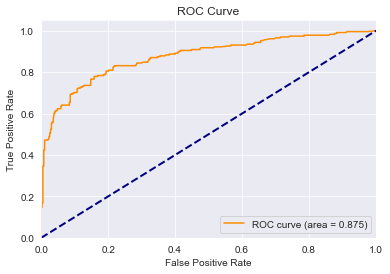

In [204]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(df_train_y.values.ravel(), predict_lgbm)

import matplotlib.pyplot as plt
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [205]:
Accuracy_Rate = (tp + tn) / (tp + tn + fp + fn)
Recall_Rate = tp / (tp + fn)
Precision_Rate = tp / (tp + fp)
Specificity_Rate = tn / (tn + fp)
F1_Score = (Precision_Rate * Recall_Rate) / (Precision_Rate + Recall_Rate) * 2

print("3. Model Metric Sumamry")
print(" - Accuracy Rate    : {:2.3f} %".format(Accuracy_Rate*100))
print(" - Recall Rate      : {:2.3f} %".format(Recall_Rate*100))
print(" - Precision Rate   : {:2.3f} %".format(Precision_Rate*100))
print(" - Specificity Rate : {:2.3f} %".format(Specificity_Rate*100))
print(" - F1 Score         : {:2.3f} ".format(F1_Score*100))
print(" - ROC AUC          : {:2.3f} ".format(roc_auc*100))

3. Model Metric Sumamry
 - Accuracy Rate    : 82.183 %
 - Recall Rate      : 64.069 %
 - Precision Rate   : 84.091 %
 - Specificity Rate : 92.857 %
 - F1 Score         : 72.727 
 - ROC AUC          : 87.543 


1. Counfusion Matrix
                   True Value 0  True Value 1
Predicted Value 0           144            36
Predicted Value 1            13            75

2. Classification Report
              precision    recall  f1-score   support

           0       0.80      0.92      0.85       157
           1       0.85      0.68      0.75       111

    accuracy                           0.82       268
   macro avg       0.83      0.80      0.80       268
weighted avg       0.82      0.82      0.81       268



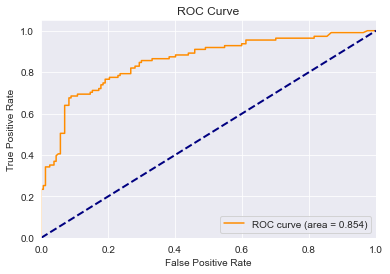

3. Model Metric Sumamry
 - Accuracy Rate    : 81.716 %
 - Recall Rate      : 67.568 %
 - Precision Rate   : 85.227 %
 - Specificity Rate : 91.720 %
 - F1 Score         : 75.377 
 - ROC AUC          : 85.405 


In [206]:
predict_lgbm = lgbm.predict_proba(df_val_x.values)[:,1]
pred_val = np.where(predict_lgbm > opt_threshold, 1., 0.)

tp, fn, fp, tn = confusion_matrix(df_val_y.values.ravel(), pred_val, labels=[1,0]).ravel()

conf_matrix = pd.DataFrame(
    confusion_matrix(df_val_y.values.ravel(), pred_val),
    columns=['Predicted Value 0', 'Predicted Value 1'],
    index=['True Value 0', 'True Value 1']
)

print("1. Counfusion Matrix")
print(conf_matrix.T)
print("")

print("2. Classification Report")
print(classification_report(df_val_y.values.ravel(), pred_val))

from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(df_val_y.values.ravel(), predict_lgbm)

import matplotlib.pyplot as plt
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Accuracy_Rate = (tp + tn) / (tp + tn + fp + fn)
Recall_Rate = tp / (tp + fn)
Precision_Rate = tp / (tp + fp)
Specificity_Rate = tn / (tn + fp)
F1_Score = (Precision_Rate * Recall_Rate) / (Precision_Rate + Recall_Rate) * 2

print("3. Model Metric Sumamry")
print(" - Accuracy Rate    : {:2.3f} %".format(Accuracy_Rate*100))
print(" - Recall Rate      : {:2.3f} %".format(Recall_Rate*100))
print(" - Precision Rate   : {:2.3f} %".format(Precision_Rate*100))
print(" - Specificity Rate : {:2.3f} %".format(Specificity_Rate*100))
print(" - F1 Score         : {:2.3f} ".format(F1_Score*100))
print(" - ROC AUC          : {:2.3f} ".format(roc_auc*100))

1. Counfusion Matrix
                   True Value 0  True Value 1
Predicted Value 0           265            24
Predicted Value 1             1           128

2. Classification Report
              precision    recall  f1-score   support

           0       0.92      1.00      0.95       266
           1       0.99      0.84      0.91       152

    accuracy                           0.94       418
   macro avg       0.95      0.92      0.93       418
weighted avg       0.94      0.94      0.94       418



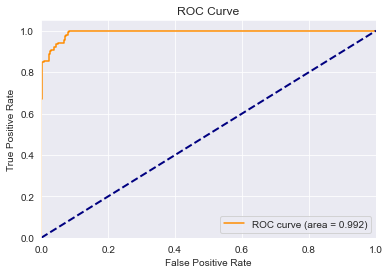

3. Model Metric Sumamry
 - Accuracy Rate    : 94.019 %
 - Recall Rate      : 84.211 %
 - Precision Rate   : 99.225 %
 - Specificity Rate : 99.624 %
 - F1 Score         : 91.103 
 - ROC AUC          : 99.221 


In [207]:
predict_lgbm = lgbm.predict_proba(df_test_x.values)[:,1]
pred_test = np.where(predict_lgbm > opt_threshold, 1., 0.)

tp, fn, fp, tn = confusion_matrix(df_test_y.values.ravel(), pred_test, labels=[1,0]).ravel()

conf_matrix = pd.DataFrame(
    confusion_matrix(df_test_y.values.ravel(), pred_test),
    columns=['Predicted Value 0', 'Predicted Value 1'],
    index=['True Value 0', 'True Value 1']
)

print("1. Counfusion Matrix")
print(conf_matrix.T)
print("")

print("2. Classification Report")
print(classification_report(df_test_y.values.ravel(), pred_test))

from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(df_test_y.values.ravel(), predict_lgbm)

import matplotlib.pyplot as plt
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Accuracy_Rate = (tp + tn) / (tp + tn + fp + fn)
Recall_Rate = tp / (tp + fn)
Precision_Rate = tp / (tp + fp)
Specificity_Rate = tn / (tn + fp)
F1_Score = (Precision_Rate * Recall_Rate) / (Precision_Rate + Recall_Rate) * 2

print("3. Model Metric Sumamry")
print(" - Accuracy Rate    : {:2.3f} %".format(Accuracy_Rate*100))
print(" - Recall Rate      : {:2.3f} %".format(Recall_Rate*100))
print(" - Precision Rate   : {:2.3f} %".format(Precision_Rate*100))
print(" - Specificity Rate : {:2.3f} %".format(Specificity_Rate*100))
print(" - F1 Score         : {:2.3f} ".format(F1_Score*100))
print(" - ROC AUC          : {:2.3f} ".format(roc_auc*100))

## 제출자료 작성

In [208]:
import datetime

# 현재 날짜와 시각 구하기
now = datetime.datetime.now()
date_list = [now.month, now.day, now.hour, now.minute, now.second]
# 현재 날짜와 시각 출력하기
print("현재 날짜 및 시각 : ", date_list)



현재 날짜 및 시각 :  [5, 20, 15, 10, 7]


In [209]:
gender_submission = pd.read_csv(data_path + 'gender_submission.csv' , index_col= 'PassengerId')
gender_submission

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


In [210]:
test_result= pd.DataFrame(pred_test)

test_result.columns = ['Survived']
predict = test_result['Survived'].tolist()
# Id_No = df_test['PassengerId']
gender_submission['Survived'] = predict

# gender_submission['Survived'] = predict
#
# # submission = pd.DataFrame({"Survived": predict})
gender_submission['Survived'] = gender_submission['Survived'].astype('Int64')

#
#
#제출 파일 생성

gender_submission.to_csv(f'submission_LightGBM_{date_list[0]}_{date_list[1]}_{date_list[2]}_{date_list[3]}_{date_list[4]}.csv')
#
#
gender_submission

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0
